# Scoring wtih Saved ML Models Generated from the Sampled NYC Taxi Trip and Fare Dataset 

## Here we show some how to load models that are stored in blobs, and score data-sets with these stored models.

OBJECTIVE: To use models and files to be scroed, that are stored in blob storage, to produce scored data and save that data to blob storage.

## Settting Directory Paths in Mapped Blob Storage Prior to Running

Where models/files are being saved in the blob, the path needs to be specified properly. Default container which is attached to the Spark cluster can be referenced as: "wasb//".

Models are saved in: "wasb:///user/remoteuser/NYCTaxi/Models". If this path is not set properly, models will not be loaded for scoring.

We save scored results in: "wasb:///user/remoteuser/NYCTaxi/ScoredResults". If the path to folder is incorrect, rsutls will not be saved in that folder.

### Set directory paths to models (input), data to be scored (input), and scored result files (output)

In [1]:
# 1. Location of data to be scored
taxi_test_file_loc = "wasb://mllibwalkthroughs@cdspsparksamples.blob.core.windows.net/Data/NYCTaxi/JoinedTaxiTripFare.Point1Pct.Test.tsv";

# 2. Set model storage directory path
modelDir = "wasb:///user/remoteuser/NYCTaxi/Models/"; # The last backslash is needed;

# 3. Set scored result directory path
scoredResultDir = "wasb:///user/remoteuser/NYCTaxi/ScoredResults/"; # The last backslash is needed;

### Path to specific models to be used for scoring (copy and paste from the bottom of the model training notebook)

In [2]:
logisticRegFileLoc = modelDir + "LogisticRegressionWithLBFGS_2016-04-0718_02_18.158911"
linearRegFileLoc = modelDir + "LinearRegressionWithSGD_2016-04-0718_05_50.275074"
randomForestClassificationFileLoc = modelDir + "RandomForestClassification_2016-04-0718_04_43.815946"
randomForestRegFileLoc = modelDir + "RandomForestRegression_2016-04-0718_06_25.457863"
BoostedTreeClassificationFileLoc = modelDir + "GradientBoostingTreeClassification_2016-04-0718_05_06.929440"
BoostedTreeRegressionFileLoc = modelDir + "GradientBoostingTreeRegression_2016-04-0718_06_53.473171"

#### PRINT START TIME

In [3]:
import datetime
datetime.datetime.now()

datetime.datetime(2016, 4, 7, 18, 29, 22, 753259)

## Set spark context and import necessary libraries

In [4]:
import pyspark
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SQLContext
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
from pyspark.sql import Row
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *
import atexit
from numpy import array
import numpy as np
import datetime

sc = SparkContext(conf=SparkConf().setMaster('yarn-client'))
sqlContext = SQLContext(sc)
atexit.register(lambda: sc.stop())

sc.defaultParallelism

2

## Data ingestion: Read in joined 0.1% taxi trip and fare file (as tsv), format and clean data, and create data-frame

In [5]:
timestart = datetime.datetime.now()

## IMPORT FILE FROM PUBLIC BLOB

taxi_test_file = sc.textFile(taxi_test_file_loc)

## GET SCHEMA OF THE FILE FROM HEADER
taxi_header = taxi_test_file.filter(lambda l: "medallion" in l)

## PARSE FIELDS AND CONVERT DATA TYPE FOR SOME FIELDS
taxi_temp = taxi_test_file.subtract(taxi_header).map(lambda k: k.split("\t"))\
        .map(lambda p: (p[0],p[1],p[2],p[3],p[4],p[5],p[6],int(p[7]),int(p[8]),int(p[9]),int(p[10]),
                        float(p[11]),float(p[12]),p[13],p[14],p[15],p[16],p[17],p[18],float(p[19]),
                        float(p[20]),float(p[21]),float(p[22]),float(p[23]),float(p[24]),int(p[25]),int(p[26])))
    
## GET SCHEMA OF THE FILE FROM HEADER
schema_string = taxi_test_file.first()
fields = [StructField(field_name, StringType(), True) for field_name in schema_string.split('\t')]
fields[7].dataType = IntegerType() #Pickup hour
fields[8].dataType = IntegerType() # Pickup week
fields[9].dataType = IntegerType() # Weekday
fields[10].dataType = IntegerType() # Passenger count
fields[11].dataType = FloatType() # Trip time in secs
fields[12].dataType = FloatType() # Trip distance
fields[19].dataType = FloatType() # Fare amount
fields[20].dataType = FloatType() # Surcharge
fields[21].dataType = FloatType() # Mta_tax
fields[22].dataType = FloatType() # Tip amount
fields[23].dataType = FloatType() # Tolls amount
fields[24].dataType = FloatType() # Total amount
fields[25].dataType = IntegerType() # Tipped or not
fields[26].dataType = IntegerType() # Tip class
taxi_schema = StructType(fields)

## CREATE DATA FRAME
taxi_df_test = sqlContext.createDataFrame(taxi_temp, taxi_schema)

## CREATE A CLEANED DATA-FRAME BY DROPPING SOME UN-NECESSARY COLUMNS & FILTERING FOR UNDESIRED VALUES OR OUTLIERS
## CREATE A CLEANED DATA-FRAME BY DROPPING SOME UN-NECESSARY COLUMNS & FILTERING FOR UNDESIRED VALUES OR OUTLIERS
taxi_df_test_cleaned = taxi_df_test.drop('medallion').drop('hack_license').drop('store_and_fwd_flag').drop('pickup_datetime')\
    .drop('dropoff_datetime').drop('pickup_longitude').drop('pickup_latitude').drop('dropoff_latitude')\
    .drop('dropoff_longitude').drop('tip_class').drop('total_amount').drop('tolls_amount').drop('mta_tax')\
    .drop('direct_distance').drop('surcharge')\
    .filter("passenger_count > 0 and passenger_count < 8 AND payment_type in ('CSH', 'CRD') AND tip_amount >= 0 AND tip_amount < 30 AND fare_amount >= 1 AND fare_amount < 150 AND trip_distance > 0 AND trip_distance < 100 AND trip_time_in_secs > 30 AND trip_time_in_secs < 7200" )

## CACHE DATA-FRAME IN MEMORY & MATERIALIZE DF IN MEMORY
taxi_df_test_cleaned.cache()
taxi_df_test_cleaned.count()

## REGISTER DATA-FRAME AS A TEMP-TABLE IN SQL-CONTEXT
taxi_df_test_cleaned.registerTempTable("taxi_test")

## PRINT HOW MUCH TIME IT TOOK TO RUN THE CELL
timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds"; 

Time taken to execute above cell: 20.0 seconds


## Feature transformation and data prep for scoring with models

#### Create Traffic time feature, and indexing and one-hot encode categorical features

In [6]:
timestart = datetime.datetime.now()

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, OneHotEncoder, VectorIndexer

### CREATE FOUR BUCKETS FOR TRAFFIC TIMES
sqlStatement = """
    SELECT *,
    CASE
     WHEN (pickup_hour <= 6 OR pickup_hour >= 20) THEN "Night" 
     WHEN (pickup_hour >= 7 AND pickup_hour <= 10) THEN "AMRush" 
     WHEN (pickup_hour >= 11 AND pickup_hour <= 15) THEN "Afternoon"
     WHEN (pickup_hour >= 16 AND pickup_hour <= 19) THEN "PMRush"
    END as TrafficTimeBins
    FROM taxi_test 
"""
taxi_df_test_with_newFeatures = sqlContext.sql(sqlStatement)

## CACHE DATA-FRAME IN MEMORY & MATERIALIZE DF IN MEMORY
taxi_df_test_with_newFeatures.cache()
taxi_df_test_with_newFeatures.count()

## INDEX AND ONE-HOT ENCODING
stringIndexer = StringIndexer(inputCol="vendor_id", outputCol="vendorIndex")
model = stringIndexer.fit(taxi_df_test_with_newFeatures) # Input data-frame is the cleaned one from above
indexed = model.transform(taxi_df_test_with_newFeatures)
encoder = OneHotEncoder(dropLast=False, inputCol="vendorIndex", outputCol="vendorVec")
encoded1 = encoder.transform(indexed)

stringIndexer = StringIndexer(inputCol="rate_code", outputCol="rateIndex")
model = stringIndexer.fit(encoded1)
indexed = model.transform(encoded1)
encoder = OneHotEncoder(dropLast=False, inputCol="rateIndex", outputCol="rateVec")
encoded2 = encoder.transform(indexed)

stringIndexer = StringIndexer(inputCol="payment_type", outputCol="paymentIndex")
model = stringIndexer.fit(encoded2)
indexed = model.transform(encoded2)
encoder = OneHotEncoder(dropLast=False, inputCol="paymentIndex", outputCol="paymentVec")
encoded3 = encoder.transform(indexed)

stringIndexer = StringIndexer(inputCol="TrafficTimeBins", outputCol="TrafficTimeBinsIndex")
model = stringIndexer.fit(encoded3)
indexed = model.transform(encoded3)
encoder = OneHotEncoder(dropLast=False, inputCol="TrafficTimeBinsIndex", outputCol="TrafficTimeBinsVec")
encodedFinal = encoder.transform(indexed)

timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds"; 

Time taken to execute above cell: 5.29 seconds


#### Creating labeledpoint RDD objects for input into models

In [7]:
timestart = datetime.datetime.now()

from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.feature import StandardScaler, StandardScalerModel
from pyspark.mllib.util import MLUtils
from numpy import array

# INDEXING CATEGORICAL TEXT FEATURES FOR INPUT INTO TREE-BASED MODELS
def parseRowIndexingBinary(line):
    features = np.array([line.paymentIndex, line.vendorIndex, line.rateIndex, line.TrafficTimeBinsIndex,
                         line.pickup_hour, line.weekday, line.passenger_count, line.trip_time_in_secs, 
                         line.trip_distance, line.fare_amount])
    labPt = LabeledPoint(line.tipped, features)
    return  labPt

# ONE-HOT ENCODING OF CATEGORICAL TEXT FEATURES FOR INPUT INTO LOGISTIC RERESSION MODELS
def parseRowOneHotBinary(line):
    features = np.concatenate((np.array([line.pickup_hour, line.weekday, line.passenger_count,
                                        line.trip_time_in_secs, line.trip_distance, line.fare_amount]), 
                                        line.vendorVec.toArray(), line.rateVec.toArray(), 
                                        line.paymentVec.toArray(), line.TrafficTimeBinsVec.toArray()), axis=0)
    labPt = LabeledPoint(line.tipped, features)
    return  labPt

# ONE-HOT ENCODING OF CATEGORICAL TEXT FEATURES FOR INPUT INTO TREE-BASED MODELS
def parseRowIndexingRegression(line):
    features = np.array([line.paymentIndex, line.vendorIndex, line.rateIndex, line.TrafficTimeBinsIndex, 
                         line.pickup_hour, line.weekday, line.passenger_count, line.trip_time_in_secs, 
                         line.trip_distance, line.fare_amount])
    labPt = LabeledPoint(line.tip_amount, features)
    return  labPt

# INDEXING CATEGORICAL TEXT FEATURES FOR INPUT INTO LINEAR REGRESSION MODELS
def parseRowOneHotRegression(line):
    features = np.concatenate((np.array([line.pickup_hour, line.weekday, line.passenger_count,
                                        line.trip_time_in_secs, line.trip_distance, line.fare_amount]), 
                                        line.vendorVec.toArray(), line.rateVec.toArray(), 
                                        line.paymentVec.toArray(), line.TrafficTimeBinsVec.toArray()), axis=0)
    labPt = LabeledPoint(line.tip_amount, features)
    return  labPt


################################################
# FOR BINARY CLASSIFICATION TRAINING AND TESTING
################################################
indexedTESTbinary = encodedFinal.map(parseRowIndexingBinary)
oneHotTESTbinary = encodedFinal.map(parseRowOneHotBinary)

################################################
# FOR REGRESSION CLASSIFICATION TRAINING AND TESTING
################################################
indexedTESTreg = encodedFinal.map(parseRowIndexingRegression)
oneHotTESTreg = encodedFinal.map(parseRowOneHotRegression)

################################################
# SCALING FEATURES FOR LINEARREGRESSIONWITHSGD MODEL
################################################
label = oneHotTESTreg.map(lambda x: x.label)
features = oneHotTESTreg.map(lambda x: x.features)
scaler = StandardScaler(withMean=False, withStd=True).fit(features)
dataTMP = label.zip(scaler.transform(features.map(lambda x: Vectors.dense(x.toArray()))))
oneHotTESTregScaled = dataTMP.map(lambda x: LabeledPoint(x[0], x[1]))

timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds"; 

Time taken to execute above cell: 10.12 seconds


### Scoring with saved Logistic Regression Model, and saving output to blob

Area under PR = 0.985561411624
Area under ROC = 0.983648167707
Summary Stats
Precision = 0.984418554785
Recall = 0.984418554785
F1 Score = 0.984418554785


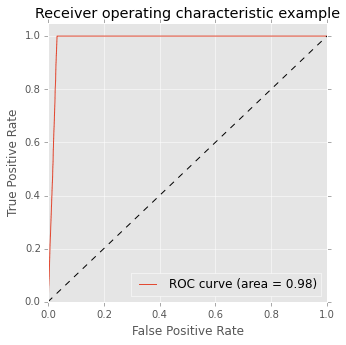

Time taken to execute above cell: 54.31 seconds


In [8]:
timestart = datetime.datetime.now()

from pyspark.mllib.classification import LogisticRegressionModel
from sklearn.metrics import roc_curve,auc
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics


####################################
## LOAD SAVED MODEL
####################################
savedModel = LogisticRegressionModel.load(sc, logisticRegFileLoc)
predictionAndLabels = oneHotTESTbinary.map(lambda lp: (float(savedModel.predict(lp.features)), lp.label))

####################################
## SAVE SCORED RESULTS (RDD) TO BLOB
####################################
datestamp = unicode(datetime.datetime.now()).replace(' ','').replace(':','_');
logisticregressionfilename = "LogisticRegressionWithLBFGS_" + datestamp + ".txt";
dirfilename = scoredResultDir + logisticregressionfilename;
predictionAndLabels.saveAsTextFile(dirfilename)

####################################
## EVALUATE SAVED MODEL USING ACCURACY METRICS
####################################
# Instantiate metrics object
metrics = BinaryClassificationMetrics(predictionAndLabels)
# Area under precision-recall curve
print("Area under PR = %s" % metrics.areaUnderPR)
# Area under ROC curve
print("Area under ROC = %s" % metrics.areaUnderROC)
metrics = MulticlassMetrics(predictionAndLabels)
# Overall statistics
precision = metrics.precision()
recall = metrics.recall()
f1Score = metrics.fMeasure()
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)


# CREATE A PANDAS DATA-FRAME AND PLOT ROC-CURVE, FROM PREDICTED PROBS AND LABELS                                     
savedModel.clearThreshold()# This clears threshold for classification (0.5) and outputs probabilities
predictionAndLabels = oneHotTESTbinary.map(lambda lp: (float(savedModel.predict(lp.features)), lp.label))
predictionAndLabelsDF = predictionAndLabels.toDF()
test_predictions = predictionAndLabelsDF.toPandas()
predictions_pddf = test_predictions.rename(columns={'_1': 'probability', '_2': 'label'})

prob = predictions_pddf["probability"] 
fpr, tpr, thresholds = roc_curve(predictions_pddf['label'], prob, pos_label=1);
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds"; 

### Scoring Linear Regression Models, and saving output to blob

In [9]:
timestart = datetime.datetime.now()

from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD, LinearRegressionModel
from pyspark.mllib.evaluation import RegressionMetrics
from scipy import stats

# LOAD MODEL AND SCORE USING ** SCALED VARIABLES **
savedModel = LinearRegressionModel.load(sc, linearRegFileLoc)
predictionAndLabels = oneHotTESTregScaled.map(lambda lp: (float(savedModel.predict(lp.features)), lp.label))

# EVALUATE MODEL
testMetrics = RegressionMetrics(predictionAndLabels)
print("RMSE = %s" % testMetrics.rootMeanSquaredError)
print("R-sqr = %s" % testMetrics.r2)

# SAVE RESULTS
datestamp = unicode(datetime.datetime.now()).replace(' ','').replace(':','_');
linearregressionfilename = "LinearRegressionWithSGD_" + datestamp;
dirfilename = scoredResultDir + linearregressionfilename;

predictionAndLabels.saveAsTextFile(dirfilename)

timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds"; 

RMSE = 1.2524372322
R-sqr = 0.619780748191
Time taken to execute above cell: 47.72 seconds


### Scoring Random Forest Models (Classification and Regression), and saving output to blob

Area under ROC = 0.985572886748
RMSE = 0.925336486487
R-sqr = 0.730084136779


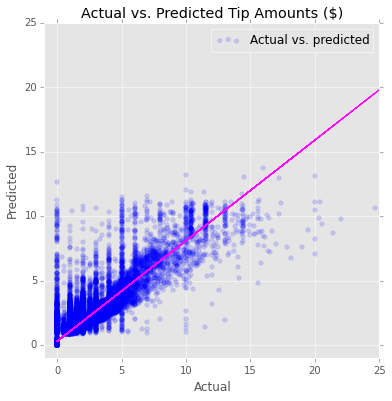

Time taken to execute above cell: 152.0 seconds


In [10]:
timestart = datetime.datetime.now()

from pyspark.mllib.tree import RandomForest, RandomForestModel

####################################
## CLASSIFICATION: LOAD SAVED MODEL, SCORE AND SAVE RESULTS BACK TO BLOB
####################################
savedModel = RandomForestModel.load(sc, randomForestClassificationFileLoc)
predictions = savedModel.predict(indexedTESTbinary.map(lambda x: x.features))
predictionAndLabels = indexedTESTbinary.map(lambda lp: lp.label).zip(predictions)

metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

# SAVE RESULTS
datestamp = unicode(datetime.datetime.now()).replace(' ','').replace(':','_');
rfclassificationfilename = "RandomForestClassification_" + datestamp + ".txt";
dirfilename = scoredResultDir + rfclassificationfilename;
predictionAndLabels.saveAsTextFile(dirfilename)


####################################
## REGRESSION: LOAD SAVED MODEL, SCORE AND SAVE RESULTS BACK TO BLOB
####################################
savedModel = RandomForestModel.load(sc, randomForestRegFileLoc)
predictions = savedModel.predict(indexedTESTreg.map(lambda x: x.features))
predictionAndLabels = indexedTESTreg.map(lambda lp: lp.label).zip(predictions)

testMetrics = RegressionMetrics(predictionAndLabels)
print("RMSE = %s" % testMetrics.rootMeanSquaredError)
print("R-sqr = %s" % testMetrics.r2)

# SAVE RESULTS
datestamp = unicode(datetime.datetime.now()).replace(' ','').replace(':','_');
rfregressionfilename = "RandomForestRegression_" + datestamp + ".txt";
dirfilename = scoredResultDir + rfregressionfilename;
predictionAndLabels.saveAsTextFile(dirfilename)

# PLOT SCATTER-PLOT BETWEEN ACTUAL AND PREDICTED TIP VALUES
test_predictions= sqlContext.createDataFrame(predictionAndLabels)
test_predictions_pddf = test_predictions.toPandas()

ax = test_predictions_pddf.plot(kind='scatter', figsize = (6,6), x='_1', y='_2', color='blue', alpha = 0.15, label='Actual vs. predicted');
fit = np.polyfit(test_predictions_pddf['_1'], test_predictions_pddf['_2'], deg=1)
ax.set_title('Actual vs. Predicted Tip Amounts ($)')
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
ax.plot(test_predictions_pddf['_1'], fit[0] * test_predictions_pddf['_1'] + fit[1], color='magenta')
plt.axis([-1, 25, -1, 25])
plt.show(ax)

timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds"; 

### Scoring with saved Gradient Boosting Tree Models, and saving output to blob

In [11]:
timestart = datetime.datetime.now()

from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel

####################################
## CLASSIFICATION: LOAD SAVED MODEL, SCORE AND SAVE RESULTS BACK TO BLOB
####################################
savedModel = GradientBoostedTreesModel.load(sc, BoostedTreeClassificationFileLoc)
predictions = savedModel.predict(indexedTESTbinary.map(lambda x: x.features))
predictionAndLabels = indexedTESTbinary.map(lambda lp: lp.label).zip(predictions)

metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

# SAVE RESULTS
datestamp = unicode(datetime.datetime.now()).replace(' ','').replace(':','_');
btclassificationfilename = "GradientBoostingTreeClassification_" + datestamp + ".txt";
dirfilename = scoredResultDir + btclassificationfilename;
predictionAndLabels.saveAsTextFile(dirfilename)


####################################
## REGRESSION: LOAD SAVED MODEL, SCORE AND SAVE RESULTS BACK TO BLOB
####################################
savedModel = GradientBoostedTreesModel.load(sc, BoostedTreeRegressionFileLoc)
predictions = savedModel.predict(indexedTESTreg.map(lambda x: x.features))
predictionAndLabels = indexedTESTreg.map(lambda lp: lp.label).zip(predictions)

testMetrics = RegressionMetrics(predictionAndLabels)
print("RMSE = %s" % testMetrics.rootMeanSquaredError)
print("R-sqr = %s" % testMetrics.r2)


# SAVE RESULTS
datestamp = unicode(datetime.datetime.now()).replace(' ','').replace(':','_');
btregressionfilename = "GradientBoostingTreeRegression_" + datestamp + ".txt";
dirfilename = scoredResultDir + btregressionfilename;
predictionAndLabels.saveAsTextFile(btregressionfilename)

timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds"; 

Area under ROC = 0.985572886748
RMSE = 0.945038735223
R-sqr = 0.72806205162
Time taken to execute above cell: 99.02 seconds


## Cleanup objects from memory, print final time, and print scored file locations

#### Unpersist objects cached in memory

In [12]:
taxi_df_test_cleaned.unpersist()

DataFrame[vendor_id: string, rate_code: string, pickup_hour: int, pickup_week: int, weekday: int, passenger_count: int, trip_time_in_secs: float, trip_distance: float, payment_type: string, fare_amount: float, tip_amount: float, tipped: int]

#### Print out path to scored output files

In [13]:
print "logisticRegFileLoc: " + logisticregressionfilename;
print "linearRegFileLoc: " + linearregressionfilename;
print "randomForestClassificationFileLoc: " + rfclassificationfilename;
print "randomForestRegFileLoc: " + rfregressionfilename;
print "BoostedTreeClassificationFileLoc: " + btclassificationfilename;
print "BoostedTreeRegressionFileLoc: " + btregressionfilename;

logisticRegFileLoc: LogisticRegressionWithLBFGS_2016-04-0718_30_45.344582.txt
linearRegFileLoc: LinearRegressionWithSGD_2016-04-0718_32_01.384031
randomForestClassificationFileLoc: RandomForestClassification_2016-04-0718_33_06.655659.txt
randomForestRegFileLoc: RandomForestRegression_2016-04-0718_34_01.243828.txt
BoostedTreeClassificationFileLoc: GradientBoostingTreeClassification_2016-04-0718_35_26.230385.txt
BoostedTreeRegressionFileLoc: GradientBoostingTreeRegression_2016-04-0718_36_19.161919.txt


#### Print finish time

In [14]:
datetime.datetime.now()

datetime.datetime(2016, 4, 7, 18, 36, 35, 902334)